# Load Dataset

In [1]:
!mkdir -p dataset/scamps_videos_example/matrix
!mkdir -p dataset/scamps_videos_example/labels
!mkdir modules

In [2]:
! wget https://facesyntheticspubwedata.blob.core.windows.net/neurips-2022/scamps_videos_example.tar.gz
! tar -xzvf scamps_videos_example.tar.gz -C dataset/scamps_videos_example/matrix
! mv dataset/scamps_videos_example/matrix/scamps_videos_example/* dataset/scamps_videos_example/matrix
! rm -rf dataset/scamps_videos_example/matrix/scamps_videos_example
! rm scamps_videos_example.tar.gz

--2024-06-12 08:33:32--  https://facesyntheticspubwedata.blob.core.windows.net/neurips-2022/scamps_videos_example.tar.gz
Resolving facesyntheticspubwedata.blob.core.windows.net (facesyntheticspubwedata.blob.core.windows.net)... 20.38.109.4
Connecting to facesyntheticspubwedata.blob.core.windows.net (facesyntheticspubwedata.blob.core.windows.net)|20.38.109.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1228897063 (1.1G) [application/octet-stream]
Saving to: 'scamps_videos_example.tar.gz'

scamps_videos_examp 100%[===================>]   1.14G  12.0MB/s    in 89s     

2024-06-12 08:35:01 (13.2 MB/s) - 'scamps_videos_example.tar.gz' saved [1228897063/1228897063]

scamps_videos_example/
scamps_videos_example/P000009.mat
scamps_videos_example/P000010.mat
scamps_videos_example/P000008.mat
scamps_videos_example/P000001.mat
scamps_videos_example/P000002.mat
scamps_videos_example/P000003.mat
scamps_videos_example/P000004.mat
scamps_videos_example/P000005.mat
scamps

In [3]:
! pip install kaggle
! pip install pykalman

In [4]:
! kaggle datasets download -d emmanuelolateju/scamps-mini-labels -p dataset/scamps_videos_example/labels
! unzip dataset/scamps_videos_example/labels/scamps-mini-labels.zip -d dataset/scamps_videos_example/labels/
! rm dataset/scamps_videos_example/labels/scamps-mini-labels.zip

Dataset URL: https://www.kaggle.com/datasets/emmanuelolateju/scamps-mini-labels
License(s): unknown
  0%|                                                | 0.00/170k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 170k/170k [00:00<00:00, 83.1MB/s]
Archive:  dataset/scamps_videos_example/labels/scamps-mini-labels.zip
  inflating: dataset/scamps_videos_example/labels/000001.csv  
  inflating: dataset/scamps_videos_example/labels/000002.csv  
  inflating: dataset/scamps_videos_example/labels/000003.csv  
  inflating: dataset/scamps_videos_example/labels/000004.csv  
  inflating: dataset/scamps_videos_example/labels/000005.csv  
  inflating: dataset/scamps_videos_example/labels/000006.csv  
  inflating: dataset/scamps_videos_example/labels/000007.csv  
  inflating: dataset/scamps_videos_example/labels/000008.csv  
  inflating: dataset/scamps_videos_example/labels/000009.csv  
  inflating: dataset/scamps_videos_example/labels/000010.csv  


In [7]:
! wget https://raw.githubusercontent.com/emmanuel-olateju/rPPG/main/modules/__init__.py -O modules/__init__.py
! wget https://raw.githubusercontent.com/emmanuel-olateju/rPPG/main/modules/processing.py -O modules/processing.py

--2024-06-12 08:40:13--  https://raw.githubusercontent.com/emmanuel-olateju/rPPG/main/modules/__init__.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52 [text/plain]
Saving to: 'modules/__init__.py'

modules/__init__.py 100%[===================>]      52  --.-KB/s    in 0s      

2024-06-12 08:40:13 (1.19 MB/s) - 'modules/__init__.py' saved [52/52]

--2024-06-12 08:40:14--  https://raw.githubusercontent.com/emmanuel-olateju/rPPG/main/modules/processing.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10655 (10K) [text/plain]

# Installations, Imports, Pre-definitions


In [8]:
import random
import os
import h5py
import numpy as np
import pandas as pd

import math

import matplotlib.pyplot as plt

import cv2
import importlib
from modules import processing
importlib.reload(processing)

from scipy.signal import butter, find_peaks
from pykalman import KalmanFilter

#### Pre-definitions and Modules

In [9]:
frame_standardization = processing.StandardizeFrame(
    target_resolution=(640,480),
    target_frame_rate=30,
    target_color_space=cv2.COLOR_BGR2RGB)

face_detect = processing.FaceDetection()
ppgi = processing.PPGIcomputation(alpha=0.5,filter_size=5,target_frame_size=(640,480))
HR = processing.HRcompute2(0.6,4,4,30)
HR2 = processing.HRcompute(0.6,4,4,30)
ibi_HR = processing.ibi_HRcompute(0.4,4,4,30)

# Compute PPG Signals

In [10]:
scamps_dir = "dataset/scamps_videos_example/matrix/"

matrix_files = os.listdir(scamps_dir)

scamps = []
for f,file in enumerate(matrix_files):
    if file != ".ipynb_checkpoints":
        scamps.append(h5py.File(scamps_dir+file,"r")["RawFrames"])

for s in range(len(scamps)):
    scamps[s] = np.asarray(scamps[s])
    print(f"File: {s} Loaded")

scamps = np.array(scamps)
scamps = scamps*255
scamps = scamps.astype("uint8")
print(scamps.min(), scamps.max())

print(scamps.shape)
print(type(scamps))

File: 0 Loaded
File: 1 Loaded
File: 2 Loaded
File: 3 Loaded
File: 4 Loaded
File: 5 Loaded
File: 6 Loaded
File: 7 Loaded
File: 8 Loaded
File: 9 Loaded
0 255
(10, 3, 320, 240, 600)
<class 'numpy.ndarray'>


In [11]:
# @title Make use of 1seconds frames

scamps = np.split(scamps,int(600/30),axis=-1)

print(type(scamps),len(scamps),type(scamps[0]),scamps[0].shape)

<class 'list'> 20 <class 'numpy.ndarray'> (10, 3, 320, 240, 30)


In [12]:
scamps = np.array(scamps)

print(scamps.shape)
print(type(scamps))

(20, 10, 3, 320, 240, 30)
<class 'numpy.ndarray'>


In [13]:
scamps = scamps.reshape(200,3,320,240,30)
scamps = np.moveaxis(scamps,[0,1,2,3,4],[0,4,2,3,1])

print(type(scamps), scamps.shape)

<class 'numpy.ndarray'> (200, 30, 320, 240, 3)


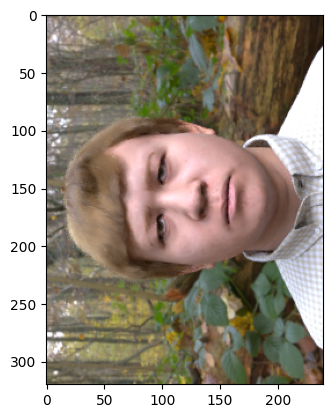

In [14]:
plt.imshow(scamps[7,2,::])

In [15]:
scamps_ = []
i = 1

while len(scamps)>0:
    for s in range(50):
        _ = np.array(frame_standardization.standardize(scamps[s],current_frame_rate=30))
        assert _.min()>=0 and _.max()<=255
        _ = (_*255).astype("uint8")
        scamps_.append(_)
    scamps = np.delete(scamps,list(range(50)),axis=0)
    print(i,scamps.shape, len(scamps_),scamps_[-1].shape)
    i += 1
    
scamps_std = np.array(scamps_)
del scamps_
scamps_std = np.moveaxis(scamps_std, [0,1,2,3,4], [0,1,3,2,4])
print(type(scamps_std),scamps_std.shape)

1 (150, 30, 320, 240, 3) 50 (30, 480, 640, 3)
2 (100, 30, 320, 240, 3) 100 (30, 480, 640, 3)
3 (50, 30, 320, 240, 3) 150 (30, 480, 640, 3)
4 (0, 30, 320, 240, 3) 200 (30, 480, 640, 3)
<class 'numpy.ndarray'> (200, 30, 640, 480, 3)


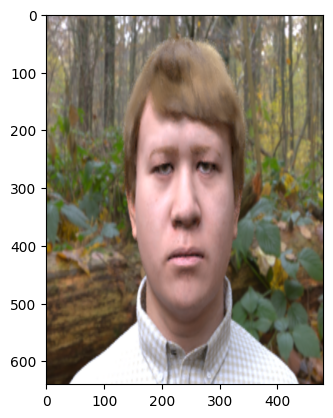

In [16]:
plt.imshow(scamps_std[7,2,::])

In [17]:
ppgi_signals = []

for s,scamp in enumerate(scamps_std): 
    
    frames_ = []
    faces, frames = face_detect.extract(scamp)
    for f in range(len(frames)):
        if len(faces[f])==1:
            for (x, y, w, h) in faces[f]:
                frame = frames[f][y+5:(y+h)-5,x+5:(x+w)-5,:]
                frames_.append(frame)
        else:
            frames_.append(frames[f])
            
    facial_skins, cks = ppgi.extract_face(frames_)
#     facial_skins = frames_
#     signal_ = ppgi.compute_ppgi(facial_skins, [0]*len(facial_skins))
    signal_ = ppgi.compute_ppgi(facial_skins, cks)
    signal_ = ppgi.compute_ppg(np.array(signal_))
            
    ppgi_signals.append(signal_)
    
ppgi_signals = np.array(ppgi_signals)
print(type(ppgi_signals), ppgi_signals.shape)

<class 'numpy.ndarray'> (200, 30)


In [18]:
# for p in range(len(ppgi_signals)):
#     ppgi_signals[p] = (ppgi_signals[p] - ppgi_signals[p].min())/(ppgi_signals[p].max()-ppgi_signals[p].min())
    
print(ppgi_signals.min(), ppgi_signals.max())
print(type(ppgi_signals), ppgi_signals.shape)

0.24085143789554014 31314.877124486084
<class 'numpy.ndarray'> (200, 30)


# Compute Target Heart Rates

In [19]:
scamps_labels_dir = "dataset/scamps_videos_example/labels/"
scamps_labels = []
for f,file in enumerate(matrix_files):
    if file != ".ipynb_checkpoints":
        file_ = file[1:7]+".csv"
        scamps_labels.append(pd.read_csv(scamps_labels_dir+file_)["d_ppg"])

scamps_labels = np.array(scamps_labels)

print(type(scamps_labels),scamps_labels.shape)

<class 'numpy.ndarray'> (10, 600)


In [20]:
scamps_labels = np.array(np.split(scamps_labels,int(600/30),axis=-1))
print(type(scamps_labels),scamps_labels.shape)

<class 'numpy.ndarray'> (20, 10, 30)


In [21]:
scamps_labels = scamps_labels.reshape(200,30)
print(type(scamps_labels),scamps_labels.shape)

<class 'numpy.ndarray'> (200, 30)


In [22]:
heart_rates = []

for s in range(len(scamps_labels)):
    hr_ = HR.compute(scamps_labels[s])
    heart_rates.append(hr_)
heart_rates = np.array(heart_rates)

/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 30, using nperseg = 30
  warnings.warn('nperseg = {0:d} is greater than input length '


Text(0, 0.5, 'Frequency')

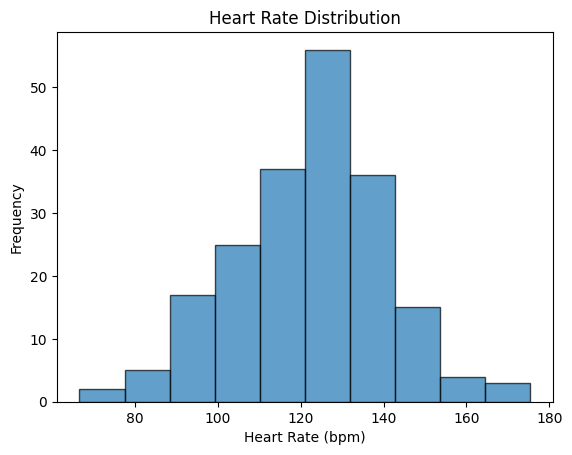

In [23]:
import matplotlib.pyplot as plt

plt.hist(heart_rates, bins=10, edgecolor='black', alpha=0.7)

# Add titles and labels
plt.title('Heart Rate Distribution')
plt.xlabel('Heart Rate (bpm)')
plt.ylabel('Frequency')

# Evaluate Performance

In [24]:
est_heart_rates = []

for signal_ in ppgi_signals:
#     kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
#     filtered_state_means, filtered_state_covariances = kf.em(signal_).filter(signal_)
#     hr_ = HR.compute(filtered_state_means.squeeze(axis=1))
    hr_ = HR.compute(signal_)
    est_heart_rates.append(hr_)

est_heart_rates = np.array(est_heart_rates)
# est_heart_rates = 0.9*est_heart_rates + 0.1*ibi_hr

In [25]:
hr_df = pd.DataFrame()

hr_df["hr"] = heart_rates
hr_df["est_hr"] = est_heart_rates
hr_df["residual"] = hr_df["hr"] - hr_df["est_hr"]

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print(
    mean_absolute_error(heart_rates, est_heart_rates),
    mean_squared_error(heart_rates, est_heart_rates)
)

41.25863952580936 2230.3750448538503


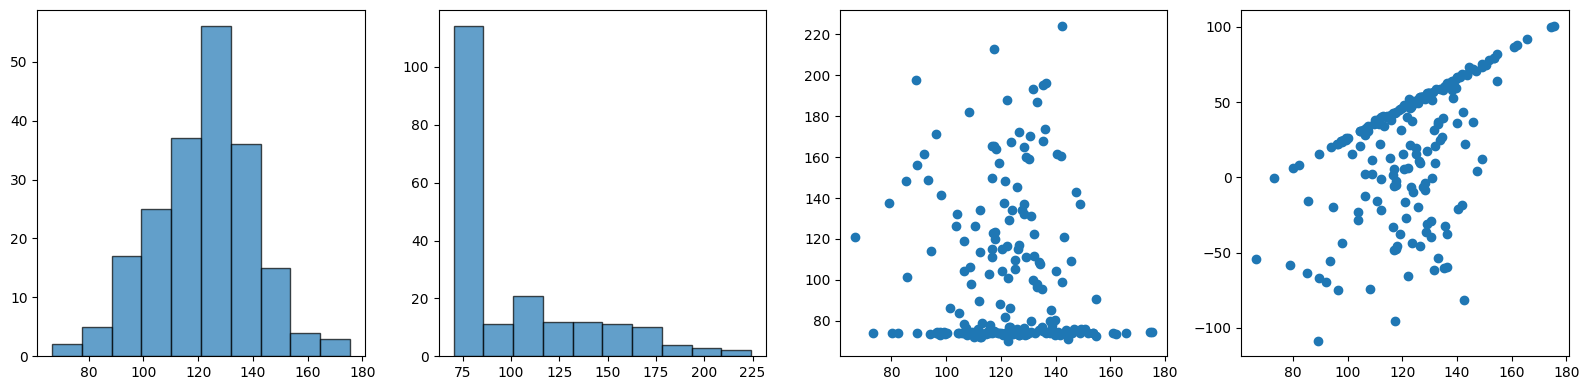

In [27]:
fig, ax = plt.subplots(1,4,figsize=(16,4))

ax[0].hist(heart_rates, bins=10, edgecolor='black', alpha=0.7)
ax[1].hist(est_heart_rates, bins=10, edgecolor='black', alpha=0.7)
ax[2].scatter(heart_rates, est_heart_rates)
ax[3].scatter(hr_df["hr"],hr_df["residual"])

fig.tight_layout()


# Train Neural Net To Map PSD to HR

In [28]:
psds = []

for signal_ in ppgi_signals:
    freqs, psd = HR.get_psd(signal_)
    psd = (psd-psd.min())/(psd.max()-psd.min())
    psds.append(np.vstack((freqs,psd)))

psds = np.array(psds).astype(np.float32)
print(type(psds),psds.shape)

<class 'numpy.ndarray'> (200, 2, 16)


/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 30, using nperseg = 30
  warnings.warn('nperseg = {0:d} is greater than input length '


In [29]:
from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler(feature_range=(0,1))

target_hr = np.array(heart_rates).reshape(-1,1).astype(np.float32)
# target_hr = scaler.fit_transform(target_hr)

print(target_hr.min(), target_hr.max())
print(type(target_hr), target_hr.shape)

66.630585 175.41513
<class 'numpy.ndarray'> (200, 1)


In [30]:
target_psds = []

for signal_ in scamps_labels:
    freqs, psd = HR.get_psd(signal_)
    psd = (psd-psd.min())/(psd.max()-psd.min())
    target_psds.append(np.array(psd))
    

target_psds = np.array(target_psds).astype(np.float32)
print(type(target_psds),target_psds.shape)

<class 'numpy.ndarray'> (200, 16)


In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

In [32]:
psds = torch.tensor(psds).cuda(0)
target_psds = torch.tensor(target_psds).cuda(0)
target_hr = torch.tensor(target_hr).cuda(0)

print(psds.size(), target_psds.size(), target_hr.size())

torch.Size([200, 2, 16]) torch.Size([200, 16]) torch.Size([200, 1])


In [33]:
# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = torch.tensor(inputs)
        self.targets = torch.tensor(targets)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_data = self.inputs[idx]
        target_data = self.targets[idx]
        return input_data, target_data

# Create dataset and dataloader
dataset = CustomDataset(psds, target_psds)


# Split the dataset into train and test sets (80% train, 20% test)
train_size = int(0.85 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create dataloaders for train and test sets
train_dataloader = DataLoader(train_dataset, batch_size=35, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=False)

train_size, test_size

/tmp/ipykernel_34/1778174863.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.inputs = torch.tensor(inputs)
/tmp/ipykernel_34/1778174863.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.tensor(targets)


(170, 30)

In [34]:
# Define the MLP model
class rPPG_PSD_MLP(nn.Module):
    def __init__(self):
        super(rPPG_PSD_MLP, self).__init__()
        self.drop1 = nn.Dropout(0.1)
        self.btc1 = nn.BatchNorm1d(32)
        self.fc1 = nn.Linear(2 * 16, 1000)  # First fully connected layer
        self.btc_conv1 = nn.BatchNorm1d(1000)
        self.conv1 = nn.Conv1d(1,1,kernel_size=101)
        self.fc2 = nn.Linear(1 * 900, 16)      # Second fully connected layer

    def forward(self, x):
        x = x.view(-1, 2 * 16)  # Flatten the input tensor
        x = self.drop1(x)
        x = self.btc1(x)
        x = F.leaky_relu(self.fc1(x))
        x = self.btc_conv1(x)
        x = x.view(x.size(0),1,x.size(-1))
        x = F.leaky_relu(self.conv1(x))
        x = x.view(x.size(0),x.size(-1))
        x = self.fc2(x)
        
        
        return x

model = rPPG_PSD_MLP()
print(model)
del model

rPPG_PSD_MLP(
  (drop1): Dropout(p=0.1, inplace=False)
  (btc1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=32, out_features=1000, bias=True)
  (btc_conv1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv1d(1, 1, kernel_size=(101,), stride=(1,))
  (fc2): Linear(in_features=900, out_features=16, bias=True)
)


In [35]:
# x_ = torch.randn((200,2,16))
# model = rPPG_PSD_MLP()
# x_ = model(x_)
# x_.size()

In [42]:
torch.manual_seed(300)

# History
history = {
    "Train_Loss": [],
    "Test_Loss": []
}

# Create the model
model = rPPG_PSD_MLP().cuda(0)

# Print the model architecture
print(model)

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

l1_lambda = 0
l2_lambda = 0

# Training loop
num_epochs = 400

for epoch in range(num_epochs):
    
    # Training loop
    model.train()
    train_loss = 0
    for batch_inputs, batch_targets in train_dataloader:
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        l2_norm = sum(((p.abs())**2).sum() for p in model.parameters())
        loss = loss + (l1_lambda*l1_norm) + (l2_lambda*l2_norm)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    train_loss /= len(train_dataloader)
    history["Train_Loss"].append(train_loss)
        
    # Evaluation loop
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for batch_inputs, batch_targets in test_dataloader:
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_targets)
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(((p.abs())**2).sum() for p in model.parameters())
            loss = loss + (l1_lambda*l1_norm) + (l2_lambda*l2_norm)
            
            test_loss += loss.item()
    test_loss /= len(test_dataloader)
    history["Test_Loss"].append(test_loss)
    
    scheduler.step(test_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}] | Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} |')

print('Training complete')

rPPG_PSD_MLP(
  (drop1): Dropout(p=0.1, inplace=False)
  (btc1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=32, out_features=1000, bias=True)
  (btc_conv1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv1d(1, 1, kernel_size=(101,), stride=(1,))
  (fc2): Linear(in_features=900, out_features=16, bias=True)
)
Epoch [1/400] | Loss: 0.0760 | Test Loss: 0.0303 |
Epoch [2/400] | Loss: 0.0407 | Test Loss: 0.0341 |
Epoch [3/400] | Loss: 0.0306 | Test Loss: 0.0306 |
Epoch [4/400] | Loss: 0.0247 | Test Loss: 0.0210 |
Epoch [5/400] | Loss: 0.0214 | Test Loss: 0.0145 |
Epoch [6/400] | Loss: 0.0189 | Test Loss: 0.0124 |
Epoch [7/400] | Loss: 0.0180 | Test Loss: 0.0117 |
Epoch [8/400] | Loss: 0.0163 | Test Loss: 0.0120 |
Epoch [9/400] | Loss: 0.0161 | Test Loss: 0.0127 |
Epoch [10/400] | Loss: 0.0156 | Test Loss: 0.0125 |
Epoch [11/400] | Loss: 0.0148 | Test Loss: 0.0132 |
Epoch [12/400

In [43]:
est_psds = torch.squeeze(model(psds).cpu(), dim=1)
est_psds = est_psds.detach().numpy()
psds_ = target_psds.cpu().detach().numpy()
print(mean_absolute_error(psds_, est_psds))

# ibi_hr = []
# for signal_ in ppgi_signals:
#     hr = ibi_HR.compute(signal_)
#     if np.isnan(hr):
#         ibi_hr.append(0)
#     else:
#         ibi_hr.append(hr)
# ibi_hr = np.array(ibi_hr)

# print(ibi_hr.shape)

y_est = []
for psd_ in est_psds:
    y_est.append(HR.compute_from_psd(np.array(list(range(16))), psd_))
y_est = np.array(y_est)
# y_est = 0.8*(np.array(y_est)) + 0.2*(ibi_hr)
y = target_hr.squeeze(axis=1).cpu()
y = y.detach().numpy()

y.shape, y_est.shape
print(mean_absolute_error(y,y_est),mean_squared_error(y,y_est))

0.049153052
16.51647210979394 437.2767856833166


In [44]:
# est_hr = torch.squeeze(model(psds).cpu(),dim=1).detach().numpy()
# hr = torch.squeeze(target_hr.cpu(),dim=1).detach().numpy()
# # hr = 0.95*hr + 0.05*ibi_hr

# print(mean_absolute_error(hr, est_hr), mean_squared_error(hr, est_hr))

# y = hr
# y_est = est_hr

In [45]:
import gc
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

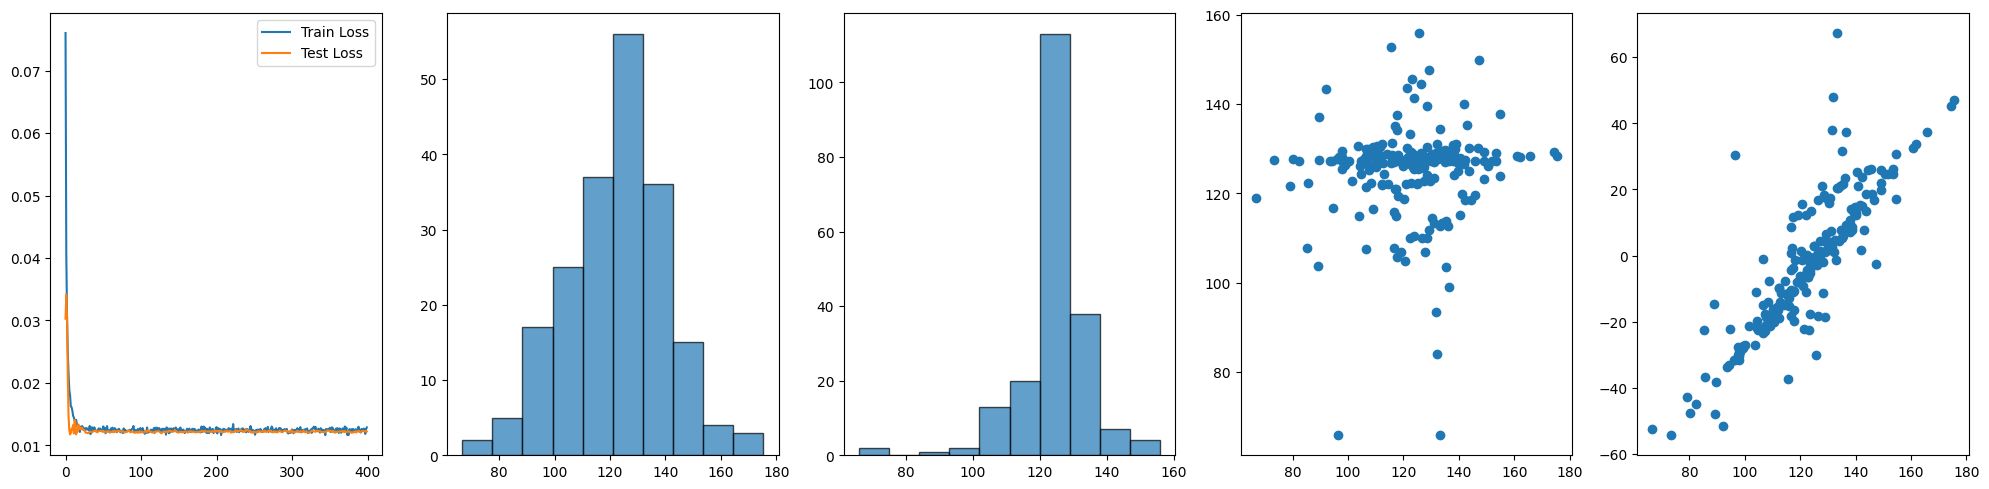

In [46]:
fig, ax = plt.subplots(1,5,figsize=(20,5))

ax[0].plot(history["Train_Loss"], label="Train Loss")
ax[0].plot(history["Test_Loss"], label="Test Loss")
ax[0].legend()

ax[1].hist(y, bins=10, edgecolor='black', alpha=0.7)

ax[2].hist(y_est, bins=10, edgecolor='black', alpha=0.7)

ax[3].scatter(y, y_est)

ax[4].scatter(y,y-y_est)

fig.tight_layout()

In [41]:
# Path to save the model
model = model.cpu()
model_path = 'model.sav'
torch.save(model.state_dict(), model_path)

# Save the PyTorch version
pytorch_version_path = 'pytorch_version.txt'
with open(pytorch_version_path, 'w') as f:
    f.write(torch.__version__)